In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sys
sys.path.append('../definitions')
import def_model as mod_def
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

Select Dates

In [2]:
start_date = pd.Timestamp('2024-03-20')
end_date = pd.Timestamp('2024-07-09')
n_lags = 0

Import data

In [3]:
df = mod_def.combine_resampled_data(start_date, end_date)

print(df.head())
print(f"This is the shape:" ,df.shape)
flag_counts = df['flag'].value_counts()
proportion_flag_1_to_0 = (flag_counts[1.0] / flag_counts[0.0])*100
print(f"Flag = 1 counts: {flag_counts[1.0]}")
print(f"Proportion of flag = 1 to flag = 0: {proportion_flag_1_to_0} %")

    NS_SQUID   Z_SQUID   NS_Fluxgate  EW_Fluxgate    Z_Fluxgate   H Component  \
0 -17.218172  0.263233  10934.303393   -42.359410 -22656.440907  10934.385443   
1 -17.199095  0.317575  10934.335773   -42.639808 -22656.444363  10934.418915   
2 -17.069690  0.255518  10934.388935   -42.276737 -22656.497270  10934.470664   
3 -17.053298  0.289818  10934.401460   -42.308557 -22656.484653  10934.483313   
4 -17.142593  0.255207  10934.392687   -42.265653 -22656.573902  10934.474373   

   flag  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  
This is the shape: (817967, 7)
Flag = 1 counts: 42983
Proportion of flag = 1 to flag = 0: 5.5463581499838055 %


Use test data

In [4]:
# Example multivariate time series data (e.g., 3 variables)
np.random.seed(42)
n_samples = 100
n_features = 3
data = np.random.rand(n_samples, n_features)

In [5]:
print(df.iloc[:, 2:7])
X, Y = mod_def.create_lagged_features(df.iloc[:, 0:7], n_lags=n_lags) #
print(f"This is the head of X", X)
# print(f"This is the head of Y", Y)

# Train-test split (without shuffling to maintain temporal order)
test_size = 0.8
split_idx = int((1 - test_size) * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

       NS_Fluxgate  EW_Fluxgate    Z_Fluxgate   H Component  flag
0     10934.303393   -42.359410 -22656.440907  10934.385443   0.0
1     10934.335773   -42.639808 -22656.444363  10934.418915   0.0
2     10934.388935   -42.276737 -22656.497270  10934.470664   0.0
3     10934.401460   -42.308557 -22656.484653  10934.483313   0.0
4     10934.392687   -42.265653 -22656.573902  10934.474373   0.0
...            ...          ...           ...           ...   ...
7339  10961.682807   -86.046363 -22642.759082  10962.020523   0.0
7340  10961.719243   -85.969953 -22642.758770  10962.056358   0.0
7341  10961.747277   -86.003307 -22642.731825  10962.084653   0.0
7342  10961.737595   -85.912318 -22642.798250  10962.074258   0.0
7343  10961.745295   -85.905466 -22642.819408  10962.081903   0.0

[817967 rows x 5 columns]
This is the head of X [[-1.72181717e+01  2.63233333e-01  1.09343034e+04 -4.23594100e+01
  -2.26564409e+04  1.09343854e+04]
 [-1.71990950e+01  3.17575000e-01  1.09343358e+04 -4.26398

Accuracy for model a C vale of 1.0: 0.9278
Classification Report for a C value of 1.0:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    619048
           1       0.23      0.15      0.18     35326

    accuracy                           0.93    654374
   macro avg       0.59      0.56      0.57    654374
weighted avg       0.91      0.93      0.92    654374

Accuracy for model a C vale of 1.0: 0.9253
Classification Report for a C value of 1.0:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    619048
           1       0.33      0.38      0.36     35326

    accuracy                           0.93    654374
   macro avg       0.65      0.67      0.66    654374
weighted avg       0.93      0.93      0.93    654374

Accuracy for model a C vale of 1.0: 0.9464
Classification Report for a C value of 1.0:
              precision    recall  f1-score   support

           0       0.98      0

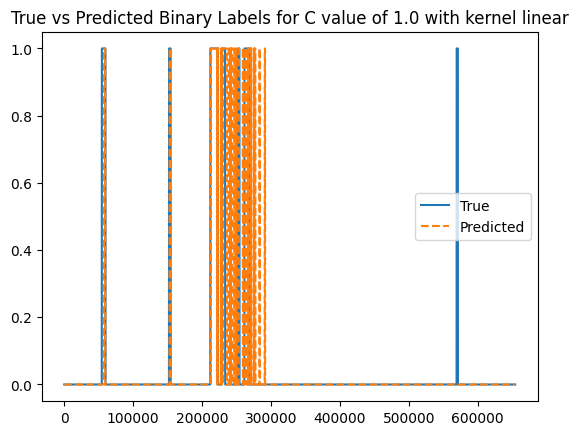

Accuracy for model a C vale of 5.0: 0.9164
Classification Report for a C value of 5.0:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    619048
           1       0.21      0.19      0.20     35326

    accuracy                           0.92    654374
   macro avg       0.58      0.57      0.58    654374
weighted avg       0.91      0.92      0.91    654374

Accuracy for model a C vale of 5.0: 0.9225
Classification Report for a C value of 5.0:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    619048
           1       0.33      0.41      0.37     35326

    accuracy                           0.92    654374
   macro avg       0.65      0.68      0.66    654374
weighted avg       0.93      0.92      0.93    654374

Accuracy for model a C vale of 5.0: 0.9457
Classification Report for a C value of 5.0:
              precision    recall  f1-score   support

           0       0.98      0

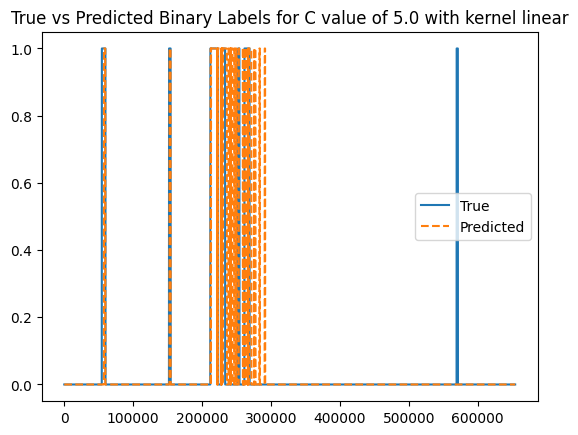

Accuracy for model a C vale of 10.0: 0.9109
Classification Report for a C value of 10.0:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    619048
           1       0.18      0.19      0.18     35326

    accuracy                           0.91    654374
   macro avg       0.57      0.57      0.57    654374
weighted avg       0.91      0.91      0.91    654374



In [6]:
kernel_list = [ 'rbf', 'poly','linear']
c_list = [1.0, 5.0, 10.0]
best_accuracy, k_best, c_best = 0, 0, 0

for i_c in c_list:
    for i_kernel in kernel_list:
        # Initialize the SVC model (Support Vector Classification)
        svc = SVC(kernel = i_kernel, C = i_c, class_weight='balanced' )

        # Train the SVC model
        svc.fit(X_train_scaled, Y_train)

        # Make predictions
        Y_pred = svc.predict(X_test_scaled)

        # Evaluate the model using classification metrics
        accuracy = accuracy_score(Y_test, Y_pred)
        if accuracy>best_accuracy:
            best_accuracy = accuracy
            k_best = i_kernel
            c_best = i_c
        print(f"Accuracy for model with a C value of {i_c} and a {i_kernel}: {accuracy:.4f}")

        # Display detailed classification metrics
        print(f"Classification Report for a C value of {i_c}:")
        print(classification_report(Y_test, Y_pred))

    plt.plot(Y_test, label="True")
    plt.plot(Y_pred, label="Predicted", linestyle='--')
    plt.title(f"True vs Predicted Binary Labels for C value of {i_c} with a {i_kernel} kernel")
    plt.legend()
    plt.show()
print(f"The best performing model used kernel {k_best} with a c value of {c_best} with an accuracy of {best_accuracy}")